In [1]:
import os
import sys
from pathlib import Path
from typing import Optional, List, Dict, Tuple

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Notebook 환경에서의 경로 기준 설정
try:
    PROJECT_DIR = Path(__file__).resolve().parent
except NameError:
    PROJECT_DIR = Path.cwd()

# SAM2 빌드 유틸 사용
from sam2.build_sam import build_sam2

print('PROJECT_DIR =', PROJECT_DIR)
print('SAM2 modules:', 'image_encoder', 'memory_attention', 'memory_encoder', 'sam_prompt_encoder', 'sam_mask_decoder')

PROJECT_DIR = /home/lji/SAM/sam2
SAM2 modules: image_encoder memory_attention memory_encoder sam_prompt_encoder sam_mask_decoder


In [2]:
# SAM2 로더

def load_sam2_model(config_file: str,
                    ckpt_path: str,
                    device: str = "cpu") -> nn.Module:
    device = torch.device(device)
    model = build_sam2(config_file=config_file, ckpt_path=ckpt_path, device=str(device), mode="eval")
    return model

print('SAM2 Loader ready.')


SAM2 Loader ready.


In [3]:
#@title SAM2 모델 파라미터
config_file = "configs/sam2.1/sam2.1_hiera_b+.yaml" #@param ["configs/sam2/sam2_hiera_t.yaml", "configs/sam2/sam2_hiera_s.yaml", "configs/sam2/sam2_hiera_b+.yaml", "configs/sam2/sam2_hiera_l.yaml", "configs/sam2.1/sam2.1_hiera_t.yaml", "configs/sam2.1/sam2.1_hiera_s.yaml", "configs/sam2.1/sam2.1_hiera_b+.yaml", "configs/sam2.1/sam2.1_hiera_l.yaml"]
ckpt_path = "./checkpoints/sam2.1_hiera_base_plus.pt" #@param {type:"string"}

device = "cpu" #@param ["cpu", "cuda"]

model = load_sam2_model(
    config_file=config_file,
    ckpt_path=ckpt_path,
    device=device,
)

print(type(model))
print("Top Children:", [n for n,_ in model.named_children()])
# SAM2에서 기본 수집 대상 모듈 미리 확인
_ = [print(' -', n) for n,_ in model.named_children() if n in ['image_encoder','memory_attention','memory_encoder','sam_prompt_encoder','sam_mask_decoder']]


<class 'sam2.modeling.sam2_base.SAM2Base'>
Top Children: ['image_encoder', 'mask_downsample', 'memory_attention', 'memory_encoder', 'sam_prompt_encoder', 'sam_mask_decoder', 'obj_ptr_proj', 'obj_ptr_tpos_proj']
 - image_encoder
 - memory_attention
 - memory_encoder
 - sam_prompt_encoder
 - sam_mask_decoder


In [4]:
from collections import defaultdict

@torch.no_grad()
def collect_weights(model: nn.Module,
                    include_bias: bool = False,
                    modules: Optional[List[str]] = None,
                    flatten: bool = True) -> Dict[str, torch.Tensor]:
    if modules is None:
        modules = [n for n,_ in model.named_children()]
    selected: List[Tuple[str, nn.Module]] = []
    for n, m in model.named_children():
        if n in modules:
            selected.append((n, m))

    out: Dict[str, torch.Tensor] = {}
    for root_name, sub in selected:
        tensors: List[torch.Tensor] = []
        for name, param in sub.named_parameters(recurse=True):
            if (name.endswith('weight')) or (include_bias and name.endswith('bias')):
                t = param.detach().float().cpu()
                tensors.append(t.reshape(-1) if flatten else t)
        if len(tensors) == 0:
            continue
        out[root_name] = torch.cat(tensors, dim=0) if flatten else tensors
    return out


def group_weights_by_layer_type(model: nn.Module,
                                include_bias: bool = False) -> Dict[str, List[torch.Tensor]]:
    groups: Dict[str, List[torch.Tensor]] = defaultdict(list)
    for name, module in model.named_modules():
        if isinstance(module, (nn.Linear, nn.Conv2d, nn.LayerNorm)):
            if hasattr(module, 'weight') and module.weight is not None:
                groups[type(module).__name__].append(module.weight.detach().float().cpu().reshape(-1))
            if include_bias and hasattr(module, 'bias') and module.bias is not None:
                groups[type(module).__name__].append(module.bias.detach().float().cpu().reshape(-1))
    return groups

print('Collectors ready.')


Collectors ready.


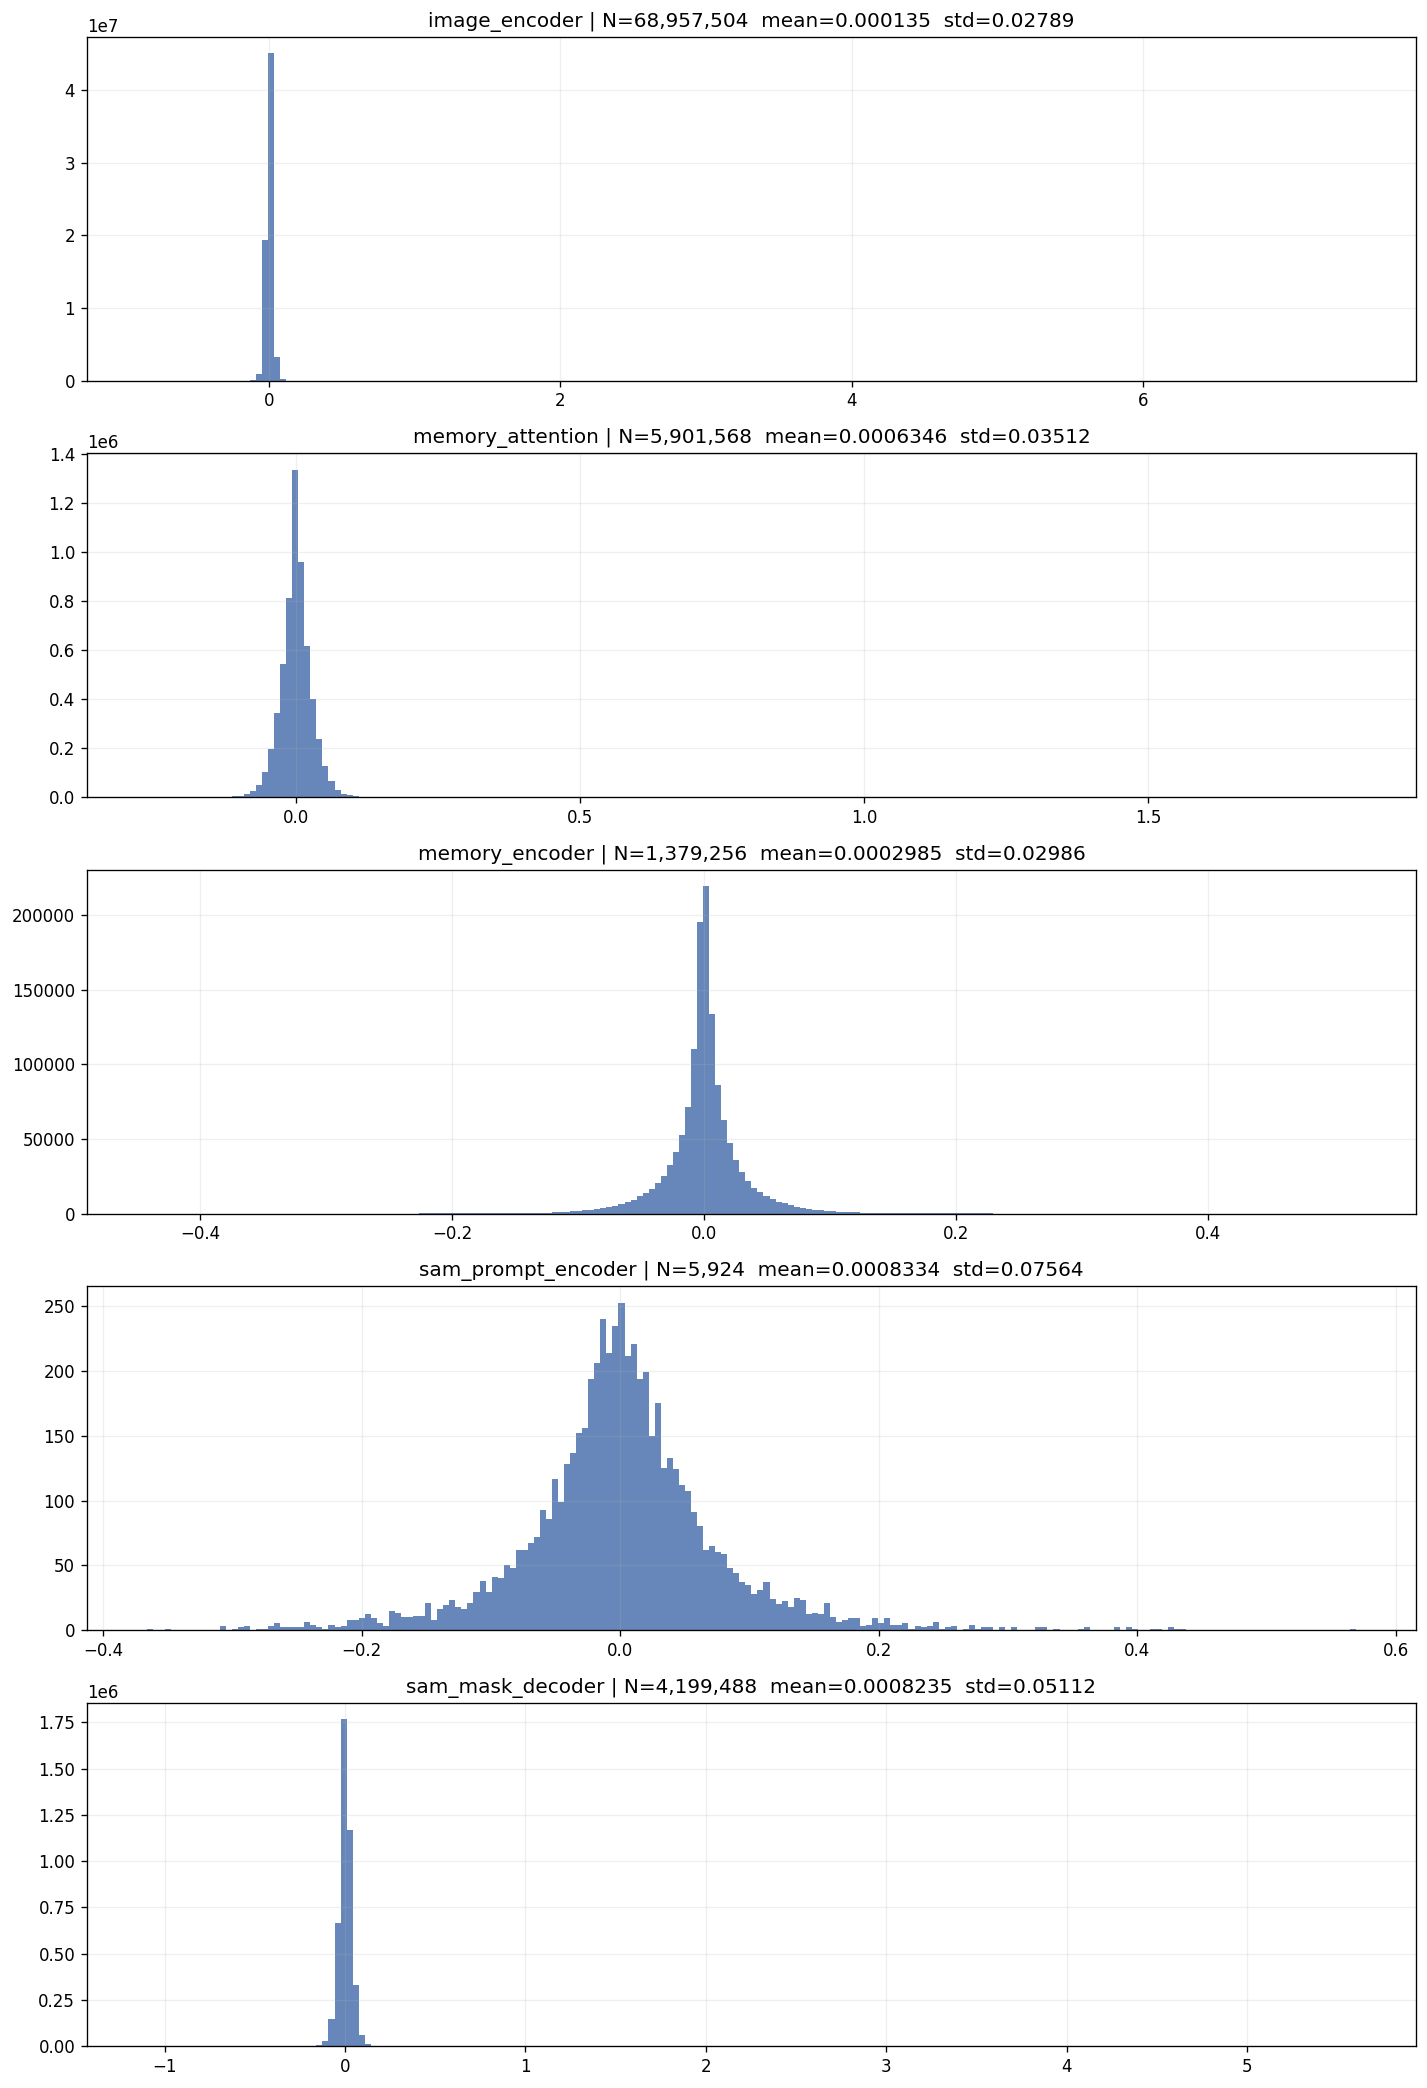

In [5]:
#@title 가중치 히스토그램 (모듈별)
include_bias = False #@param {type:"boolean"}
# SAM2 top-level 모듈에 맞춰 기본값 설정
modules = ["image_encoder", "memory_attention", "memory_encoder", "sam_prompt_encoder", "sam_mask_decoder"] #@param

weights = collect_weights(model, include_bias=include_bias, modules=modules, flatten=True)

num_bins = 200 #@param {type:"integer"}
figsize = (12, 3.5 * max(1, len(weights)))

fig, axes = plt.subplots(len(weights), 1, figsize=figsize, dpi=120)
if len(weights) == 1:
    axes = [axes]

for ax, (name, w) in zip(axes, weights.items()):
    w_np = w.numpy()
    mu, sigma = float(w_np.mean()), float(w_np.std())
    ax.hist(w_np, bins=num_bins, color="#4C72B0", alpha=0.85)
    ax.set_title(f"{name} | N={w_np.size:,}  mean={mu:.4g}  std={sigma:.4g}")
    ax.grid(True, alpha=0.2)

fig.tight_layout()
plt.show()


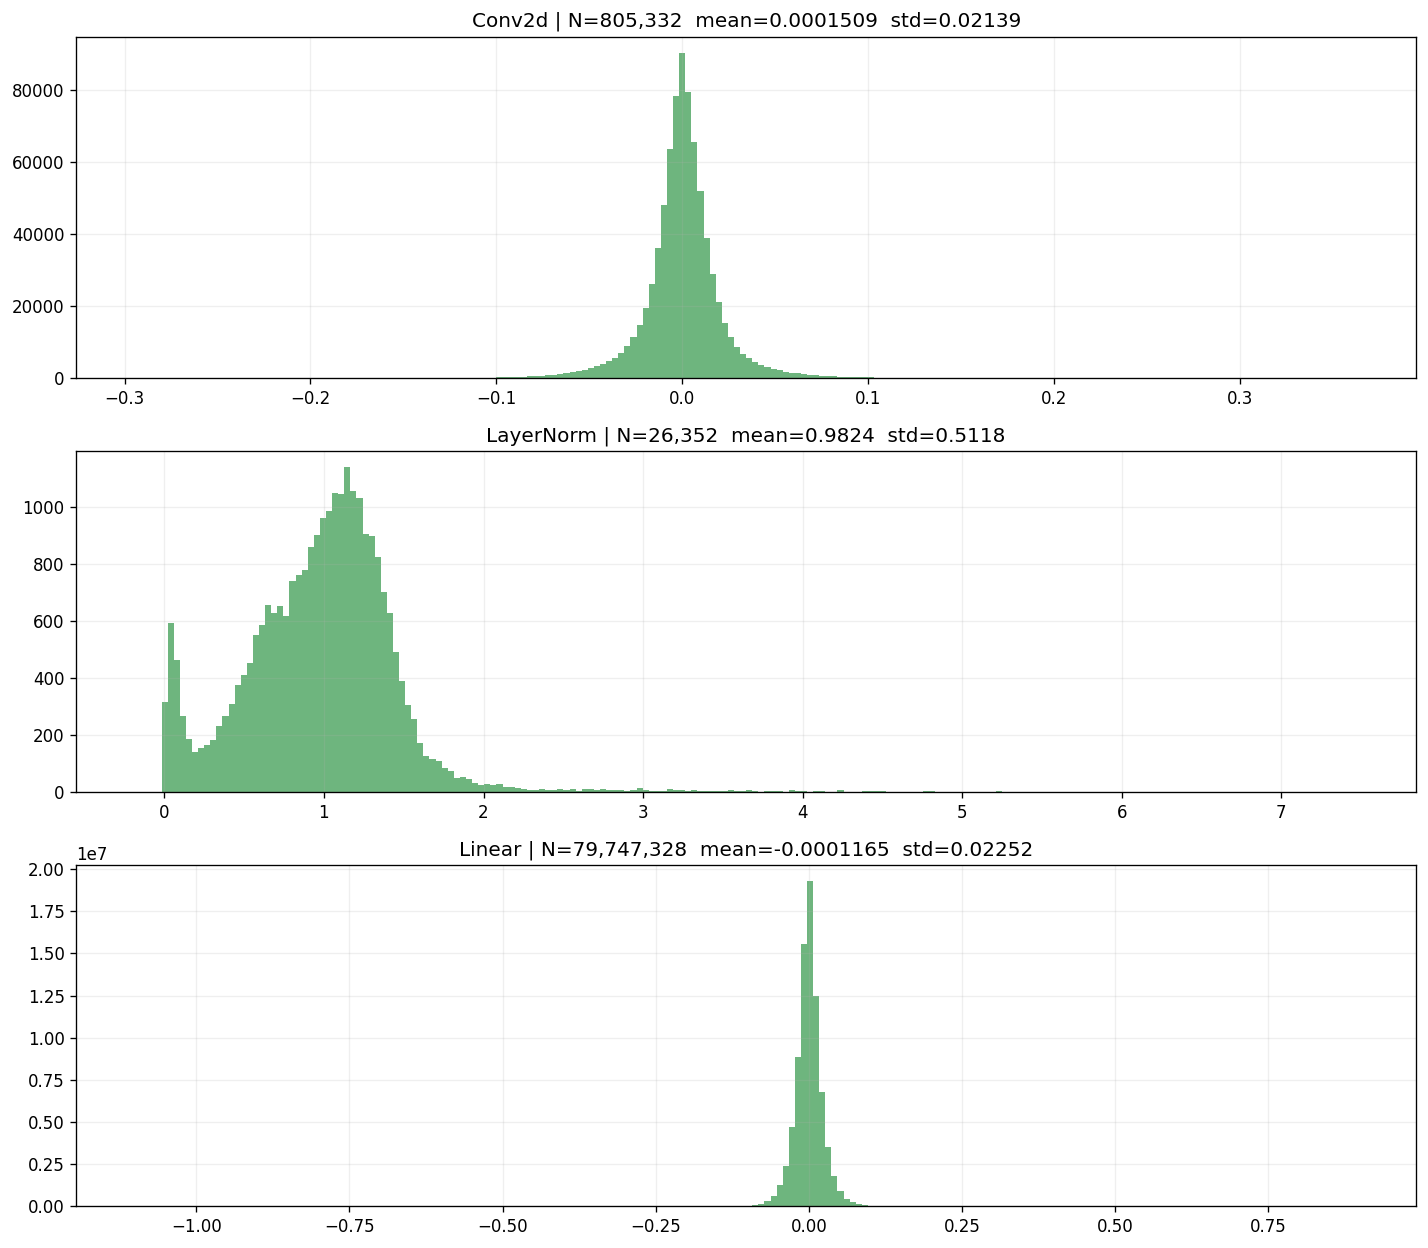

In [6]:
#@title 레이어 타입별 히스토그램 합성
include_bias_layer = False #@param {type:"boolean"}
num_bins_layer = 200 #@param {type:"integer"}

groups = group_weights_by_layer_type(model, include_bias=include_bias_layer)

n = len(groups)
fig, axes = plt.subplots(n, 1, figsize=(12, 3.5 * max(1, n)), dpi=120)
if n == 1:
    axes = [axes]
for ax, (tname, tensors) in zip(axes, groups.items()):
    if len(tensors) == 0:
        continue
    all_cat = torch.cat(tensors, dim=0)
    arr = all_cat.numpy()
    mu, sigma = float(arr.mean()), float(arr.std())
    ax.hist(arr, bins=num_bins_layer, color="#55A868", alpha=0.85)
    ax.set_title(f"{tname} | N={arr.size:,}  mean={mu:.4g}  std={sigma:.4g}")
    ax.grid(True, alpha=0.2)
fig.tight_layout()
plt.show()


In [7]:
#@title 통계 집계 및 저장 (선택)
export_dir = "./weights_dist_outputs/" + Path(ckpt_path).stem #@param {type:"string"}
save_hist_png = True #@param {type:"boolean"}
save_stats_csv = True #@param {type:"boolean"}
num_bins_export = 256 #@param {type:"integer"}

out_dir = Path(export_dir)
out_dir.mkdir(parents=True, exist_ok=True)

# 1) 모듈별 PNG 저장
if save_hist_png:
    weights = collect_weights(model, include_bias=False, modules=["image_encoder","memory_attention","memory_encoder","sam_prompt_encoder","sam_mask_decoder"], flatten=True)
    for name, w in weights.items():
        fig = plt.figure(figsize=(8,4), dpi=120)
        plt.hist(w.numpy(), bins=num_bins_export, color="#4C72B0", alpha=0.9)
        plt.title(f"{name} | N={w.numel():,}")
        plt.grid(True, alpha=0.2)
        fig.tight_layout()
        fig.savefig(out_dir / f"hist_{name}.png", bbox_inches="tight")
        plt.close(fig)

# 2) 전체 통계 CSV 저장
if save_stats_csv:
    import csv
    stats = []
    with torch.no_grad():
        for n, p in model.named_parameters():
            if p is None: continue
            if p.ndim == 0: continue
            if n.endswith("weight") or n.endswith("bias"):
                t = p.detach().float().cpu().reshape(-1)
                arr = t.numpy()
                stats.append({
                    "name": n,
                    "numel": int(arr.size),
                    "mean": float(arr.mean()),
                    "std": float(arr.std()),
                    "min": float(arr.min()),
                    "max": float(arr.max()),
                })
    with open(out_dir / "weights_stats.csv", "w", newline="", encoding="utf-8") as f:
        w = csv.DictWriter(f, fieldnames=["name","numel","mean","std","min","max"])
        w.writeheader()
        w.writerows(stats)

print("저장 완료:", out_dir)

저장 완료: weights_dist_outputs/sam2.1_hiera_base_plus


In [8]:
#@title 중첩 플롯 유틸리티 (원 가중치 밀도 + 양자화 분포 로그 카운트)
from typing import Sequence

@torch.no_grad()
def fake_quantize_per_tensor(w: torch.Tensor, w_bits: int = 8) -> torch.Tensor:
    w = w.detach().float().cpu()
    max_abs = w.abs().max()
    qmax = float(2 ** (w_bits - 1) - 1)
    scale = (max_abs / qmax) if max_abs > 0 else torch.tensor(1.0)
    q = torch.round(w / scale).clamp_(-qmax, qmax).to(torch.int8)
    dq = q.to(torch.float32) * scale
    return dq


def gaussian_smooth(y: np.ndarray, sigma: float = 1.0, radius: int = 3) -> np.ndarray:
    # 간단한 1D 가우시안 커널로 스무딩 (SciPy 없이)
    r = int(max(1, radius))
    xs = np.arange(-r, r + 1, dtype=np.float32)
    kernel = np.exp(-(xs**2) / (2.0 * (sigma**2)))
    kernel = kernel / kernel.sum()
    return np.convolve(y, kernel, mode="same")


def plot_weight_and_quant_overlay(ax, w_flat: np.ndarray, w_bits: int = 8, bins: int = 50,
                                  color_hist: str = "#6A88FF", color_kde: str = "#FF9933",
                                  label_hist: str = "quantized distribution",
                                  label_kde: str = "weight distribution"):
    # 좌측 축: 원 가중치 밀도(히스토그램→스무딩 라인)
    hist_y, hist_x = np.histogram(w_flat, bins=bins, density=True)
    centers = (hist_x[:-1] + hist_x[1:]) * 0.5
    smooth = gaussian_smooth(hist_y, sigma=1.0, radius=3)
    ax.plot(centers, smooth, color=color_kde, label=label_kde, linewidth=1.3)
    ax.set_xlabel("weight values")
    ax.set_ylabel("weight density")
    ax.grid(True, alpha=0.25)

    # 우측 축: 양자화 후 값의 발생 횟수 (로그 스케일)
    dq = fake_quantize_per_tensor(torch.from_numpy(w_flat), w_bits=w_bits).numpy()
    ax2 = ax.twinx()
    ax2.hist(dq, bins=bins, color=color_hist, alpha=0.45, label=label_hist)
    ax2.set_yscale('log')
    ax2.set_ylim(bottom=1.0)
    ax2.set_ylabel("occurrence of quantized values")

    # 범례 결합
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc='upper left')


def find_layer_weights(model: nn.Module, predicate) -> List[Tuple[str, np.ndarray]]:
    found: List[Tuple[str, np.ndarray]] = []
    for name, module in model.named_modules():
        if predicate(name, module) and hasattr(module, 'weight') and module.weight is not None:
            found.append((name, module.weight.detach().float().cpu().reshape(-1).numpy()))
    return found

print('Overlay utils ready.')

Overlay utils ready.


In [9]:
#@title 정밀 양자화 레벨 기반 중첩 플롯 유틸리티
@torch.no_grad()
def quant_levels_per_tensor(w: torch.Tensor, w_bits: int) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    대칭 signed per-tensor 양자화(레벨 수 = 2^b)를 가정하고, 레벨별 발생 횟수를 반환합니다.
    - qmin = -2^(b-1), qmax = 2^(b-1)-1 → 총 2^b개 레벨
    - 반환: (dequantized_values_sorted, counts_sorted, scale)
    """
    w = w.detach().float().cpu().reshape(-1)
    max_abs = float(w.abs().max().item())
    if max_abs == 0.0:
        scale = 1.0
    else:
        # qabs = 2^(b-1)
        qabs = float(2 ** (w_bits - 1))
        scale = max_abs / qabs
        if scale == 0.0:
            scale = 1.0
    qmin = - (2 ** (w_bits - 1))
    qmax = (2 ** (w_bits - 1)) - 1
    q = torch.round(w / scale).clamp_(qmin, qmax).to(torch.int32)
    dq = q.to(torch.float32) * scale
    vals, counts = np.unique(dq.numpy(), return_counts=True)
    return vals, counts, float(scale)


def plot_weight_and_quant_levels(ax, w_flat: np.ndarray, w_bits: int = 8,
                                 color_bar: str = "#6A88FF", color_line: str = "#FF9933",
                                 label_bar: str = "quantized distribution",
                                 label_line: str = "weight distribution"):
    # 좌측: 원 가중치 밀도(히스토그램→스무딩 라인)
    hist_y, hist_x = np.histogram(w_flat, bins=80, density=True)
    centers = (hist_x[:-1] + hist_x[1:]) * 0.5
    smooth = gaussian_smooth(hist_y, sigma=1.0, radius=3)
    ax.plot(centers, smooth, color=color_line, label=label_line, linewidth=1.3)
    ax.set_xlabel("weight values")
    ax.set_ylabel("weight density")
    ax.grid(True, alpha=0.25)

    # 우측: 정확한 양자화 레벨별 '히스토그램' (레벨 경계 중심으로 bin을 정의 + 로그축)
    # - 레벨: scale * {qmin..qmax} (총 2^b개)
    w_t = torch.from_numpy(w_flat)
    max_abs = float(w_t.abs().max().item())
    qabs = float(2 ** (w_bits - 1))
    scale = (max_abs / qabs) if max_abs > 0 else 1.0
    qmin = - (2 ** (w_bits - 1))
    qmax = (2 ** (w_bits - 1)) - 1
    # 양자화 및 dequant
    q = torch.round(w_t / scale).clamp_(qmin, qmax).to(torch.int32)
    dq = (q.to(torch.float32) * scale).numpy()
    # 레벨 중심과 bin 경계 계산 (중간점 기반)
    levels = np.arange(qmin, qmax + 1, dtype=np.float32) * scale
    if levels.size > 1:
        step = float(levels[1] - levels[0])
        edges = np.concatenate([
            [levels[0] - 0.5 * step],
            (levels[:-1] + levels[1:]) * 0.5,
            [levels[-1] + 0.5 * step],
        ])
    else:
        # 단일 레벨인 극단적 경우를 대비한 널널한 경계
        edges = np.array([levels[0] - 0.5, levels[0] + 0.5], dtype=np.float32)

    ax2 = ax.twinx()
    ax2.hist(dq, bins=edges, color=color_bar, alpha=0.45, label=label_bar)
    ax2.set_yscale('log')
    ax2.set_ylim(bottom=1.0)
    ax2.set_ylabel("occurrence of quantized values")

    # 범례 통합
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc='upper left')

print('Level-based overlay utils ready.')


Level-based overlay utils ready.


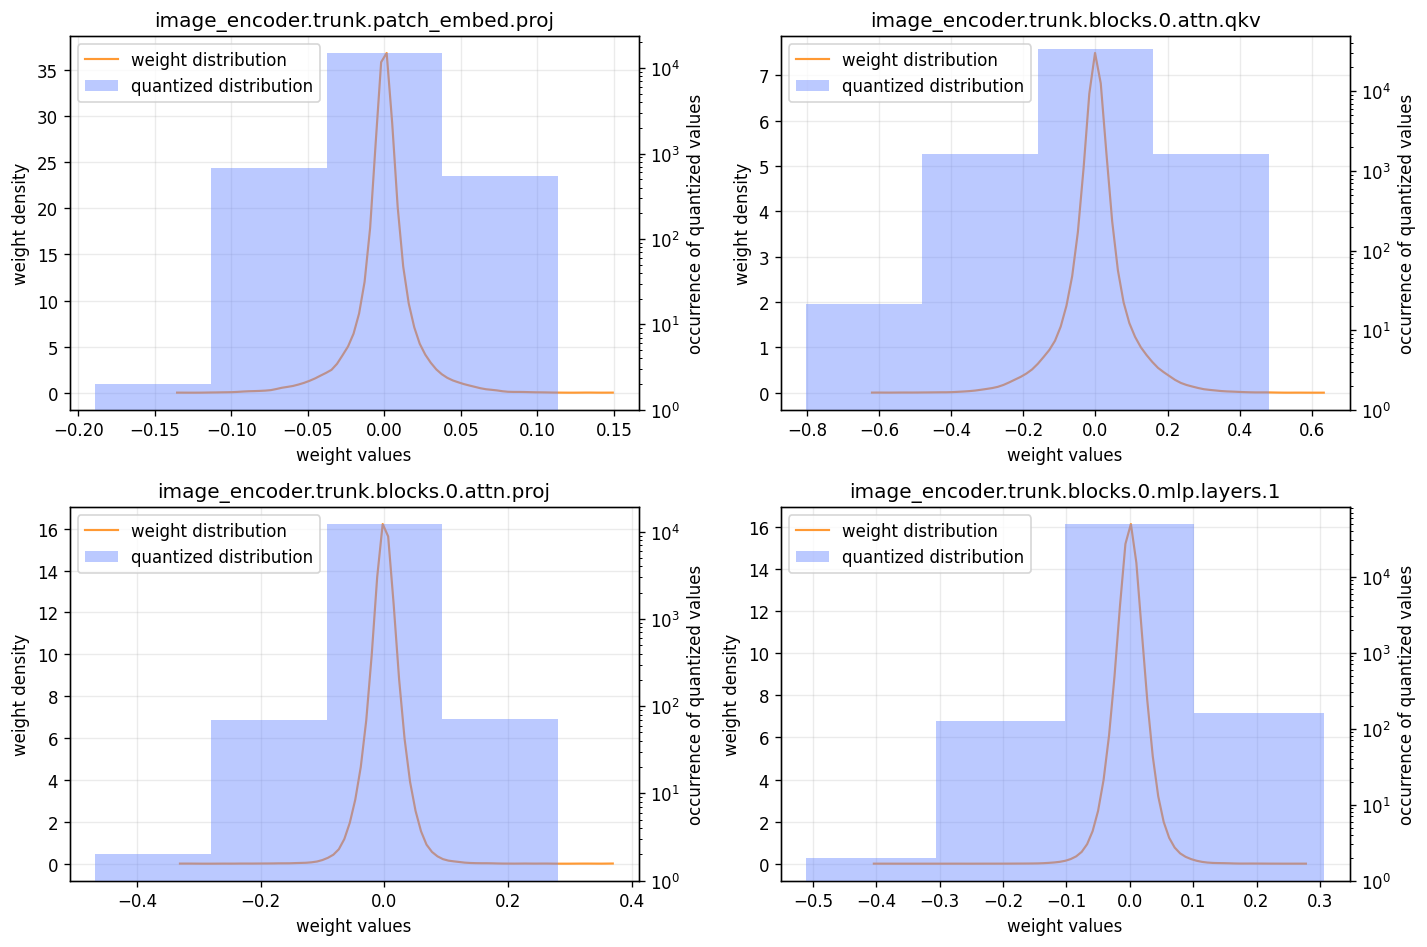

Saved: ./weights_dist_outputs/sam2.1_hiera_base_plus/overlay_example_levels.png


In [10]:
#@title 예시 2열 플롯 (정밀 레벨 기반) + 저장
import re
out_path_levels = export_dir + "/overlay_example_levels.png" #@param {type:"string"}
w_bits_levels = 2 #@param {type:"integer"}

# SAM2의 백본은 Hiera 기반이며, top-level 모듈 경로는 image_encoder.trunk/neck 하위에 존재합니다.
# Linear/Conv 가중치를 가지는 neck의 conv 또는 trunk 내 블록을 대상으로 예시 패턴을 제공합니다.
pattern_list_levels = [
    r"image_encoder\.trunk\.patch_embed\.proj$",
    r"image_encoder\.trunk\.blocks\.0\.attn\.qkv$",
    r"image_encoder\.trunk\.blocks\.0\.attn\.proj$",
    r"image_encoder\.trunk\.blocks\.0\.mlp\.layers\.1$",
] #@param

# 후보 추출
def pred_levels(name: str, module: nn.Module) -> bool:
    if not isinstance(module, (nn.Linear, nn.Conv2d)):
        return False
    for p in pattern_list_levels:
        if re.search(p, name):
            return True
    return False

cands = find_layer_weights(model, lambda n, m: pred_levels(n, m))
samples = cands[:4] if len(cands) >= 4 else cands

fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=120)
axes = np.ravel(axes)
if len(samples) == 0:
    print("선택된 레이어가 없습니다. pattern_list_levels를 조정하세요.")
else:
    for ax, (lname, wflat) in zip(axes, samples):
        plot_weight_and_quant_levels(ax, wflat, w_bits=w_bits_levels)
        ax.set_title(lname)
    fig.tight_layout()
    Path(out_path_levels).parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path_levels, bbox_inches="tight")
    plt.show()
    print("Saved:", out_path_levels)


In [11]:
#@title 전체 레이어 가중치 분포 개별 저장
import re
out_path_levels = export_dir + "/layers" #@param {type:"string"}
w_bits_levels = 4 #@param {type:"integer"}

# 전체 Linear/Conv 레이어 추출
def pred_all_levels(name: str, module: nn.Module) -> bool:
    if not isinstance(module, (nn.Linear, nn.Conv2d)):
        return False
    return True

all_layers = find_layer_weights(model, lambda n, m: pred_all_levels(n, m))

# 출력 디렉토리 생성
Path(out_path_levels).mkdir(parents=True, exist_ok=True)

if len(all_layers) == 0:
    print("Linear/Conv 레이어가 없습니다.")
else:
    print(f"총 {len(all_layers)}개 레이어의 가중치 분포를 개별 저장합니다...")
    
    for i, (lname, wflat) in enumerate(all_layers):
        # 각 레이어마다 단일 플롯 생성
        fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=120)
        plot_weight_and_quant_levels(ax, wflat, w_bits=w_bits_levels)
        ax.set_title(f"{lname}")
        
        # 파일명에서 특수문자 제거
        safe_name = re.sub(r'[^\w\-_\.]', '_', lname)
        out_file = Path(out_path_levels) / f"{i:03d}_{safe_name}.png"
        
        fig.tight_layout()
        fig.savefig(out_file, bbox_inches="tight")
        plt.close(fig)  # 메모리 절약을 위해 닫기
        
        if (i + 1) % 10 == 0:
            print(f"진행률: {i + 1}/{len(all_layers)}")
    
    print(f"완료: {len(all_layers)}개 레이어 저장됨 -> {out_path_levels}")


총 217개 레이어의 가중치 분포를 개별 저장합니다...
진행률: 10/217
진행률: 20/217
진행률: 30/217
진행률: 40/217
진행률: 50/217
진행률: 60/217
진행률: 70/217
진행률: 80/217
진행률: 90/217
진행률: 100/217
진행률: 110/217
진행률: 120/217
진행률: 130/217
진행률: 140/217
진행률: 150/217
진행률: 160/217
진행률: 170/217
진행률: 180/217
진행률: 190/217
진행률: 200/217
진행률: 210/217
완료: 217개 레이어 저장됨 -> ./weights_dist_outputs/sam2.1_hiera_base_plus/layers/
